<a href="https://colab.research.google.com/github/jasperfue/AIIM/blob/oversampling/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# (Optional) Load Data from Kaggle into Google Colab

In [100]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'aiim-emotion-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F77823%2F8553100%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240619%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240619T170057Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D5c476729b0567eedf12e63244d29dd5ede412b21448a1c7c10b8e35ba56fad8a1644085b2f93653796e18bea7c8ff99050ca5b00443d8211cd833868e95906ba2a262ce13ecdcc954c7692413292e548369385fe8d6d9a69ed262b33320390aa480bb6ab41cf22b22ecfff855a5c04e22e8a3fc119d6d34af72acc8603339e58a32f975e94e561a7168109b3ef8247cf6999118bb71b710c5ca573ccb417de7f9d8cc34b765c18d98bd7a2c54332213d9e2f86e97de1bd8aacb0efc35029a5cbfb25b93ac409ebb9eec8b5c5cf6814fa7114b9d7b68ee3487a0d6e3c1f395015e5d3244675df81bcb008516604827d92498cf18500d97688a977d4b644f44f27'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 18175099 bytes downloaded
Downloaded and uncompressed: aiim-emotion-classification
Data source import complete.


### Imports

In [101]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import os
from keras.utils import image_dataset_from_directory, load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D,  Flatten, Dense, Dropout, BatchNormalization, RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomBrightness, Rescaling
from keras.optimizers import Adam, SGD
from keras.optimizers.schedules import ExponentialDecay
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.losses import CategoricalCrossentropy
from sklearn.metrics import f1_score, confusion_matrix, classification_report

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


# Import of Data and Data Preprocessing

### Import
The Keras `image_dataset_from_directory` function provides the ability to load images and automatically assign labels based on their directory paths, which fits perfectly our data structure. Additionally, it allows for splitting the data into training and validation subsets and setting the batch size.

### Batch Size and Epochs
The choice of an appropriate batch size and number of epochs is influenced by the optimizer, learning rate, and many other factors. After testing different options, a batch size of 32 and 70 epochs was found to work well. Although 70 epochs might seem high, a technique is used that eventually reduces this number, making the training process more efficient.

In [102]:
base_directory = '/kaggle/input/aiim-emotion-classification/aiim-emotion-classification/'
batch_size = 64
epochs = 70

In [129]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import numpy as np

# Laden der Datensätze ohne direkten Split
dataset = image_dataset_from_directory(
    directory=base_directory + 'train/',
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',
    batch_size=None,  # Keine Batch-Größe, um alle Daten zu laden
    shuffle=True,
    seed=420,
    image_size=(100, 100))

# Namen der Klassen
class_names = dataset.class_names
print("Klassen:", class_names)

# Funktion zur Zählung der Bilder pro Klasse
def count_images_per_class(dataset, class_names):
    class_counts = {class_name: 0 for class_name in class_names}
    for image, label in dataset:
        class_idx = tf.argmax(label).numpy()
        class_name = class_names[class_idx]
        class_counts[class_name] += 1
    return class_counts

# Anzahl der Bilder pro Klasse im Datensatz
class_counts = count_images_per_class(dataset, class_names)
print("Anzahl der Bilder im Datensatz pro Klasse:", class_counts)

# Finden der maximalen Anzahl von Bildern in einer Klasse
max_count = max(class_counts.values())

# Funktion zum Balancieren der Klasse "fear"
def balance_class(dataset, class_name_to_balance, target_count, class_names):
    images = []
    labels = []
    for image, label in dataset:
        images.append(image.numpy())
        labels.append(label.numpy())

    images = np.array(images)
    labels = np.array(labels)

    # Finden der Indizes der zu balancierenden Klasse
    class_idx_to_balance = class_names.index(class_name_to_balance)
    class_indices = np.where(np.argmax(labels, axis=1) == class_idx_to_balance)[0]

    # Zufälliges Duplizieren der Bilder, bis die Klasse balanciert ist
    if len(class_indices) < target_count:
        additional_indices = np.random.choice(class_indices, target_count - len(class_indices))
        balanced_images = np.concatenate([images, images[additional_indices]])
        balanced_labels = np.concatenate([labels, labels[additional_indices]])
    else:
        balanced_images = images
        balanced_labels = labels

    return tf.data.Dataset.from_tensor_slices((balanced_images, balanced_labels))

# Balancieren der Klasse "fear"
balanced_dataset = balance_class(dataset, 'fear', max_count, class_names)
print("Anzahl der Bilder im balancierten Datensatz pro Klasse:", count_images_per_class(balanced_dataset, class_names))

def stratified_split(dataset, class_names, validation_split):
    class_datasets = {class_name: [] for class_name in class_names}

    for image, label in dataset:
        class_index = tf.argmax(label).numpy()  # Sicherstellen, dass class_index ein Skalar ist
        class_name = class_names[class_index]
        class_datasets[class_name].append((image, label))

    train_datasets = []
    validation_datasets = []

    for class_name, images in class_datasets.items():
        np.random.seed(42)
        np.random.shuffle(images)
        val_size = int(len(images) * validation_split)
        validation_datasets.extend(images[:val_size])
        train_datasets.extend(images[val_size:])

    np.random.shuffle(train_datasets)
    np.random.shuffle(validation_datasets)

    train_images, train_labels = zip(*train_datasets)
    val_images, val_labels = zip(*validation_datasets)

    train_ds = tf.data.Dataset.from_tensor_slices((list(train_images), list(train_labels)))
    validation_ds = tf.data.Dataset.from_tensor_slices((list(val_images), list(val_labels)))

    return train_ds, validation_ds

# Aufteilen in Trainings- und Validierungsdatensätze
validation_split = 0.15
dataset_size = len(balanced_dataset)
val_size = int(validation_split * dataset_size)

train_ds, validation_ds = stratified_split(balanced_dataset, class_names, validation_split)

print("Anzahl verschiedener Klassen training:", count_images_per_class(train_ds, class_names))
print("Anzahl verschiedener Klassen validierung:", count_images_per_class(validation_ds, class_names))

# Batch-Verarbeitung
train_ds = train_ds.batch(batch_size)
validation_ds = validation_ds.batch(batch_size)

print("Trainings- und Validierungsdatensätze erstellt und gebatcht.")


Found 9108 files belonging to 5 classes.
Klassen: ['angry', 'fear', 'happy', 'sad', 'surprise']
Anzahl der Bilder im Datensatz pro Klasse: {'angry': 2000, 'fear': 1108, 'happy': 2000, 'sad': 2000, 'surprise': 2000}
Anzahl der Bilder im balancierten Datensatz pro Klasse: {'angry': 2000, 'fear': 2000, 'happy': 2000, 'sad': 2000, 'surprise': 2000}
Anzahl verschiedener Klassen training: {'angry': 1700, 'fear': 1700, 'happy': 1700, 'sad': 1700, 'surprise': 1700}
Anzahl verschiedener Klassen validierung: {'angry': 300, 'fear': 300, 'happy': 300, 'sad': 300, 'surprise': 300}
Trainings- und Validierungsdatensätze erstellt und gebatcht.


## Normalization and Random Image Augmentation

### Normalization
All pixels of the grayscale images have values between 0 and 255. These values are normalized to lie between 0 and 1 because it provides several benefits for training Convolutional Neural Networks (CNNs). It stabilizes and makes computations more efficient by keeping the input values within a consistent and small range. This helps avoid numerical instabilities and speeds up convergence during training. Overall, normalization leads to more stable, faster, and improved performance of the neural network.
For consistency we have to normalize all data sets (train, validation, test).


### Random Image Augmentation
To decrease overfitting, we chose to use random data augmentation. This technique randomly modifies the images by, for example, rotating them, flipping them, zooming in or out, or adjusting the contrast and brightness. Keras provides various suitable image preprocessing layers for these augmentations. Selecting the appropriate layers and determining the correct parameters for the transformations is not an easy task.

If the images are augmented too much, the model may struggle to identify the important features that determine the label. Conversely, if the augmentation is too minimal, it does not significantly enhance the model's generalization capabilities.

In the end, we found that the best generalization was achieved by using a random rotation and a random zoom, which independently zooms in and out on each axis and therefore distorts the image to a certain factor.

Random data augmentation is only applied to the training data since it is useful for training the model, but not for validating or testing it.

In [130]:
normalization_layer = Rescaling(1./255)

# Documentation: https://keras.io/api/layers/preprocessing_layers/image_augmentation/
data_augmentation = Sequential([
    RandomContrast(0.0005),
    RandomBrightness(0.001),
    RandomFlip("horizontal"),
    RandomZoom(0.2, 0.2),
    RandomRotation(0.025)
])

image_batch, label_batch = next(iter(train_ds.unbatch().batch(5)))
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

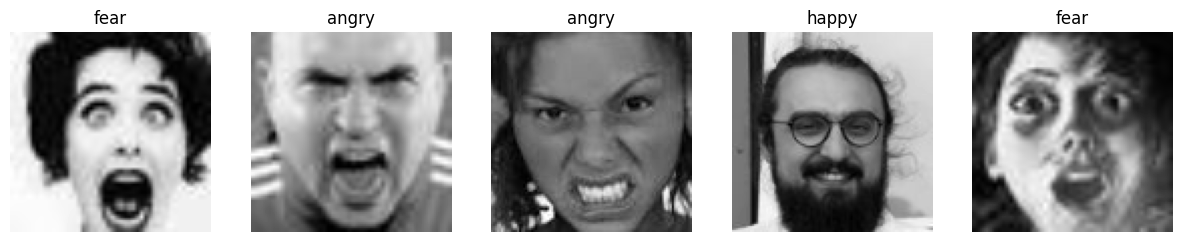

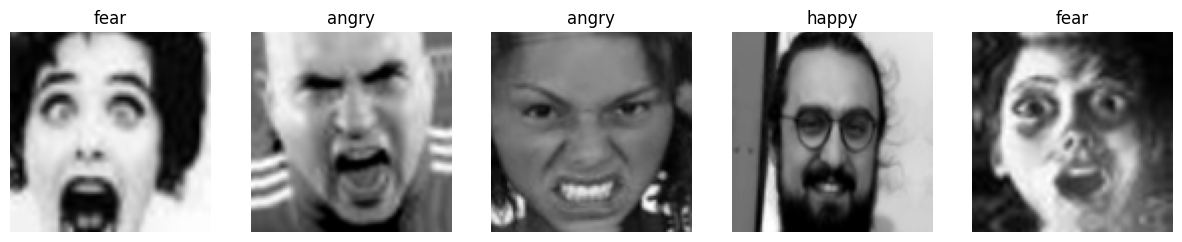

In [131]:
def plot_images(images, titles, rows=1, cols=5, figsize=(15, 5)):
    plt.figure(figsize=figsize)
    for i in range(len(images)):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

# Normalize images for visualization
normalized_images = normalization_layer(image_batch)

# Apply augmentation to the same images
augmented_images = data_augmentation(normalized_images, training=True)

# Plot original images
plot_images(normalized_images, titles=[class_names[label.numpy().argmax()] for label in label_batch], rows=2, cols=5, figsize=(15, 6))

# Plot augmented images
plot_images(augmented_images, titles=[class_names[label.numpy().argmax()] for label in label_batch], rows=2, cols=5, figsize=(15, 6))

# Scratch model

The first idea was to train and build a Convolutional Neural Network (CNN) from scratch. After evaluating different libraries like PyTorch and Tensorflow we decided to use keras.

In [132]:
train_ds_scratch = train_ds.map(lambda x, y: (normalization_layer(x), y))
validation_ds_scratch = validation_ds.map(lambda x, y: (normalization_layer(x), y))

## Create CNN Model Structure
The CNN model structure was determined through a trial-and-error process, similar to most of the hyperparameters. We experimented with different numbers of layers, varying the number of filters, padding, strides, activation functions, and kernel sizes.

In the end using no padding for all layers proved to be the most precise approach.

A stride of 1 increased the computational workload but maintained better performance.

To decrease complexity and the number of parameters, we added Max Pooling layers. They also aid in feature extraction by retaining the most important activations within a pooling window,

Additionally, we included Dropout layers to enhance the robustness of the model. Dropout layers randomly disable a fraction of the neurons during training, preventing specific neurons from becoming overly responsible for certain features, thereby improving generalization.

After flattening the multi-dimensional output of the convolutional and pooling layers into a 1D vector, we added two fully connected layers with a Dropout layer between them. This Dropout layer deactivates 50% of the neurons to further enhance generalization. We also experimented with an L2 regularizer in the first fully connected layer to increase robustness, but found that the combination of dropout layers and data augmentation yielded better results. The regularizer actually decreased the model's performance.

The final layer needed to have five output nodes to classify the five different emotions. We chose a softmax activation function for this layer because it is suitable for multi-class classification problems, as it outputs a probability distribution over the classes.

### Convolutional Layer 1
* Number of input Channels: 1 (Greyscale)
* Number of output Channels: 32
* Kernel size: 3x3
* Activation: ReLU

### Convolutional Layer 2
* Number of output Channels: 64
* Kernel size: 3x3
* Activation: ReLU

### Max Pooling Layer 1
* Kernel size: 2x2
* Stride: 2

### Dropout Layer 1
* Dropout rate: 0.25

### Convolutional Layer 3
* Number of output Channels: 128
* Kernel size: 3x3
* Stride: 1
* Activation: ReLU

### Max Pooling Layer 2
* Kernel size: 2x2
* Stride: 2

### Convolutional Layer 4
* Number of input Channels: 128
* Number of output Channels: 256
* Kernel size: 3x3
* Activation: ReLU

### Max Pooling Layer 3
* Kernel size: 2x2
* Stride: 2

### Dropout Layer 2
* Dropout rate: 0.25

### Flatten Layer
Converts the multi-dimensional output of the Convolutional and Pooling layers into a 1D vector.

### Fully Connected Layer 1
* Output features: 1028
* Activation: ReLU
* (Regularization: L2)

### Dropout Layer 3
* Dropout rate: 0.5

### Fully Connected Layer 2
* Output features: Number of classes (5 different emotions)
* Activation: Softmax

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 98, 98, 32)        320       
                                                                 
 conv2d_25 (Conv2D)          (None, 96, 96, 64)        18496     
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 48, 48, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_23 (Dropout)        (None, 48, 48, 64)        0         
                                                                 
 conv2d_26 (Conv2D)          (None, 46, 46, 128)       73856     
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 23, 23, 128)       0         
 ng2D)                                               

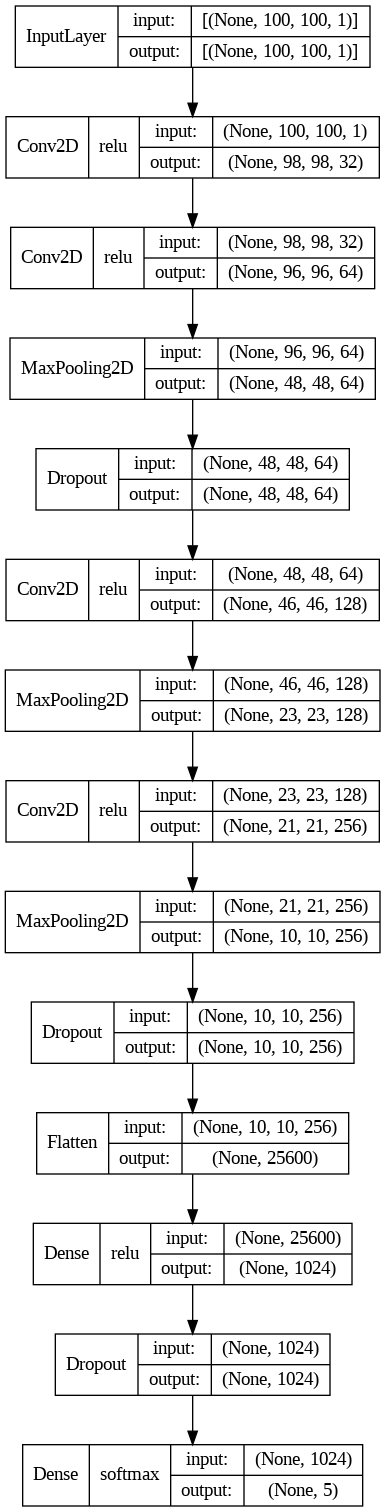

In [133]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(100,100,1)),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),


    Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(filters=256, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.25),
    Dense(5, activation='softmax')
])
model.summary()
plot_model(model, to_file="model.png", show_shapes=True, show_layer_names=False, show_layer_activations=True)


Try Learning rate of 0.001

In [134]:
# Define the optimizer
initial_learning_rate = 0.00015
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=100000, decay_rate=0.96)

optimizer = Adam(learning_rate=lr_schedule)


# Compile the model
model.compile(loss=CategoricalCrossentropy(),
              optimizer=optimizer,
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=4, min_lr=0.0001)

# Training des Modells
history = model.fit(train_ds_scratch, validation_data=validation_ds_scratch, epochs=epochs, batch_size=batch_size, callbacks=[reduce_lr, early_stopping])


Epoch 1/70
266/266 [==============================] - 12s 32ms/step - loss: 1.5604 - accuracy: 0.2835 - val_loss: 1.4636 - val_accuracy: 0.3767 - lr: 1.4998e-04
Epoch 2/70
266/266 [==============================] - 8s 29ms/step - loss: 1.3886 - accuracy: 0.4152 - val_loss: 1.2450 - val_accuracy: 0.4880 - lr: 1.4997e-04
Epoch 3/70
266/266 [==============================] - 8s 29ms/step - loss: 1.2413 - accuracy: 0.4933 - val_loss: 1.1226 - val_accuracy: 0.5500 - lr: 1.4995e-04
Epoch 4/70
266/266 [==============================] - 8s 29ms/step - loss: 1.1394 - accuracy: 0.5460 - val_loss: 1.0492 - val_accuracy: 0.5927 - lr: 1.4993e-04
Epoch 5/70
266/266 [==============================] - 8s 29ms/step - loss: 1.0708 - accuracy: 0.5732 - val_loss: 1.0047 - val_accuracy: 0.6087 - lr: 1.4992e-04
Epoch 6/70
266/266 [==============================] - 8s 29ms/step - loss: 1.0163 - accuracy: 0.6006 - val_loss: 0.9855 - val_accuracy: 0.6233 - lr: 1.4990e-04
Epoch 7/70
266/266 [===================

In [135]:
# Vorhersagen für die Validierungsdaten
y_val_true = np.concatenate([y for x, y in validation_ds_scratch], axis=0)
y_val_pred = model.predict(validation_ds_scratch)

# Umwandeln der Vorhersagen in One-Hot-Format
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true_classes = np.argmax(y_val_true, axis=1)

# F1-Score berechnen
f1 = f1_score(y_val_true_classes, y_val_pred_classes, average='weighted')
print("F1-Score: ", f1)

47/47 [==============================] - 0s 3ms/step
F1-Score:  0.7592852886790442


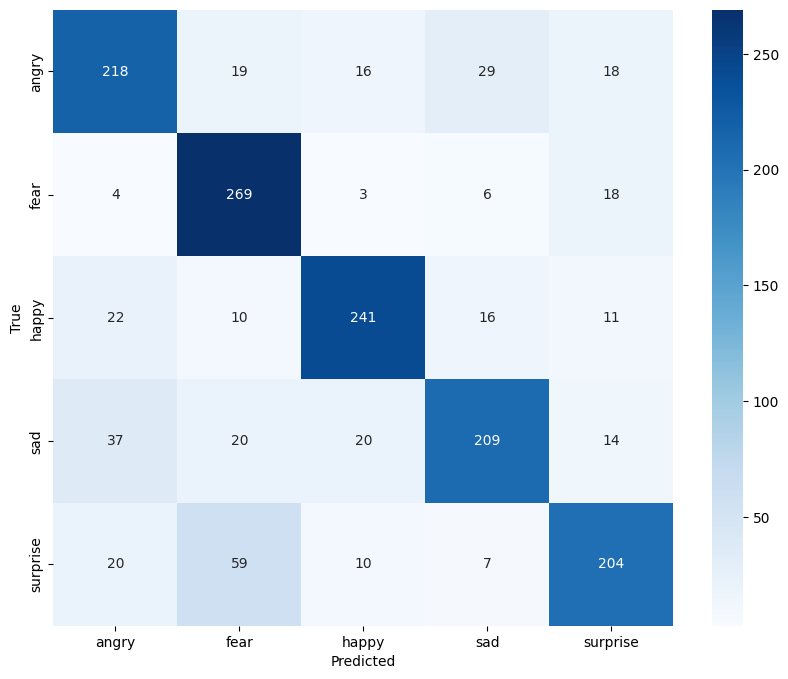

              precision    recall  f1-score   support

       angry       0.72      0.73      0.73       300
        fear       0.71      0.90      0.79       300
       happy       0.83      0.80      0.82       300
         sad       0.78      0.70      0.74       300
    surprise       0.77      0.68      0.72       300

    accuracy                           0.76      1500
   macro avg       0.76      0.76      0.76      1500
weighted avg       0.76      0.76      0.76      1500



In [136]:
# Confusion Matrix und Classification Report
cm = confusion_matrix(y_val_true_classes, y_val_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(classification_report(y_val_true_classes, y_val_pred_classes, target_names=class_names))


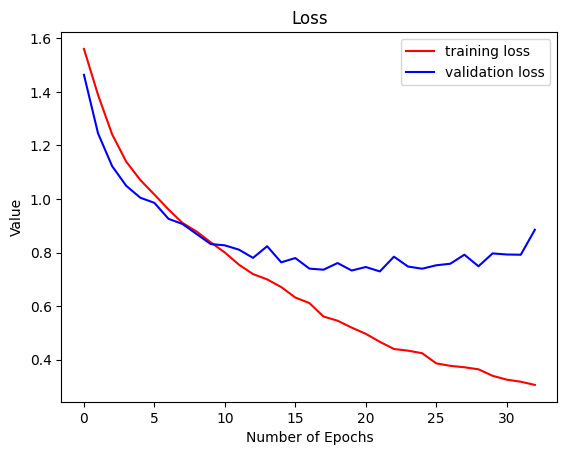

In [137]:
# Plot the loss and accuracy curves for training and validation
plt.plot(history.history['loss'], color='r', label="training loss")
plt.plot(history.history['val_loss'], color='b', label="validation loss")
plt.title("Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()

# Create Submission

In [ ]:
file_names = []
images = []
test_directory = base_directory + 'test/'

for filename in os.listdir(test_directory):
    if filename.endswith(".jpg"):
        img_path = os.path.join(test_directory, filename)
        img = load_img(img_path, target_size=(100,100), color_mode='grayscale')
        img_array = img_to_array(img)
        img_array = normalization_layer(img_array)
        images.append(img_array)
        file_names.append(filename)

# In ein numpy Array konvertieren
images_array = np.array(images)

# Vorhersagen machen
y_test = model.predict(images_array)
y_pred_indices = np.argmax(y_test, axis=1)
y_pred_labels = [class_names[idx] for idx in y_pred_indices]

# DataFrame erstellen
df = pd.DataFrame({
    'Id': file_names,
    'emotions': y_pred_labels
})

# DataFrame als CSV speichern
df.to_csv('./submission.csv', index=False)

75/75 [==============================] - 1s 8ms/step


# ResNet Model

In [138]:
from keras.layers import GlobalAveragePooling2D
from keras.applications import ResNet50
from keras.applications.resnet import preprocess_input

batch_size = 64
epochs = 70

# Since the images are grayscale, we need to convert them to RGB by repeating the grayscale channel
def to_rgb(image, label):
    image = tf.image.grayscale_to_rgb(image)
    return image, label

train_ds_rgb = train_ds.map(to_rgb)
validation_ds_rgb = validation_ds.map(to_rgb)

train_ds_resnet = train_ds_rgb.map(lambda x, y: (preprocess_input(x), y))
validation_ds_resnet = validation_ds_rgb.map(lambda x, y: (preprocess_input(x), y))


In [139]:
# Create the ResNet model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(5, activation='softmax')
])
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d_5  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_26 (Dropout)        (None, 2048)              0         
                                                                 
 dense_19 (Dense)            (None, 5)                 10245     
                                                                 
Total params: 23597957 (90.02 MB)
Trainable params: 23544837 (89.82 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [140]:
base_model.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.00001)

history = model.fit(
    train_ds_resnet,
    validation_data=validation_ds_resnet,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/70
266/266 [==============================] - 12s 34ms/step - loss: 2.0285 - accuracy: 0.3592 - val_loss: 1.3122 - val_accuracy: 0.5020 - lr: 0.0010
Epoch 2/70
266/266 [==============================] - 8s 30ms/step - loss: 1.5479 - accuracy: 0.4414 - val_loss: 1.2935 - val_accuracy: 0.4960 - lr: 0.0010
Epoch 3/70
266/266 [==============================] - 8s 30ms/step - loss: 1.4293 - accuracy: 0.4602 - val_loss: 1.1997 - val_accuracy: 0.5173 - lr: 0.0010
Epoch 4/70
266/266 [==============================] - 8s 30ms/step - loss: 1.3707 - accuracy: 0.4835 - val_loss: 1.1648 - val_accuracy: 0.5280 - lr: 0.0010
Epoch 5/70
266/266 [==============================] - 8s 29ms/step - loss: 1.3543 - accuracy: 0.4873 - val_loss: 1.2032 - val_accuracy: 0.5173 - lr: 0.0010
Epoch 6/70
266/266 [==============================] - 8s 29ms/step - loss: 1.3338 - accuracy: 0.4905 - val_loss: 1.1834 - val_accuracy: 0.5213 - lr: 0.0010
Epoch 7/70
266/266 [==============================] - 8s 29ms/s

In [141]:
# Unfreeze the base model
base_model.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are take into account
model.compile(optimizer=Adam(1e-4),  # Very low learning rate
              loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=4, min_lr=1e-6)

history_finetune = model.fit(
    train_ds_resnet,
    validation_data=validation_ds_resnet,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping, reduce_lr]
)



Epoch 1/70
266/266 [==============================] - 46s 57ms/step - loss: 1.1854 - accuracy: 0.5522 - val_loss: 0.9996 - val_accuracy: 0.6413 - lr: 1.0000e-04
Epoch 2/70
266/266 [==============================] - 13s 47ms/step - loss: 0.7663 - accuracy: 0.7086 - val_loss: 0.7938 - val_accuracy: 0.7173 - lr: 1.0000e-04
Epoch 3/70
266/266 [==============================] - 13s 47ms/step - loss: 0.5827 - accuracy: 0.7869 - val_loss: 0.7836 - val_accuracy: 0.7120 - lr: 1.0000e-04
Epoch 4/70
266/266 [==============================] - 13s 47ms/step - loss: 0.4723 - accuracy: 0.8255 - val_loss: 0.8265 - val_accuracy: 0.7233 - lr: 1.0000e-04
Epoch 5/70
266/266 [==============================] - 13s 47ms/step - loss: 0.3943 - accuracy: 0.8576 - val_loss: 0.7917 - val_accuracy: 0.7453 - lr: 1.0000e-04
Epoch 6/70
266/266 [==============================] - 13s 47ms/step - loss: 0.3312 - accuracy: 0.8829 - val_loss: 0.7552 - val_accuracy: 0.7693 - lr: 1.0000e-04
Epoch 7/70
266/266 [==============

In [142]:
# Vorhersagen für die Validierungsdaten
y_val_true = np.concatenate([y for x, y in validation_ds_resnet], axis=0)
y_val_pred = model.predict(validation_ds_resnet)

# Umwandeln der Vorhersagen in One-Hot-Format
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true_classes = np.argmax(y_val_true, axis=1)

# F1-Score berechnen
f1 = f1_score(y_val_true_classes, y_val_pred_classes, average='weighted')
print("F1-Score: ", f1)

47/47 [==============================] - 1s 8ms/step
F1-Score:  0.8326279062995432


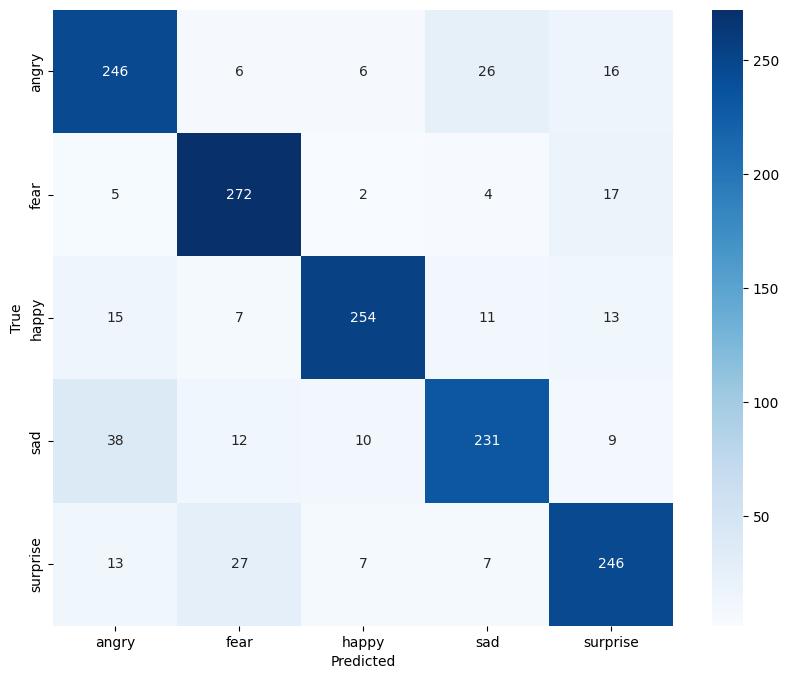

              precision    recall  f1-score   support

       angry       0.78      0.82      0.80       300
        fear       0.84      0.91      0.87       300
       happy       0.91      0.85      0.88       300
         sad       0.83      0.77      0.80       300
    surprise       0.82      0.82      0.82       300

    accuracy                           0.83      1500
   macro avg       0.83      0.83      0.83      1500
weighted avg       0.83      0.83      0.83      1500



In [143]:
# Confusion Matrix und Classification Report
cm = confusion_matrix(y_val_true_classes, y_val_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(classification_report(y_val_true_classes, y_val_pred_classes, target_names=class_names))


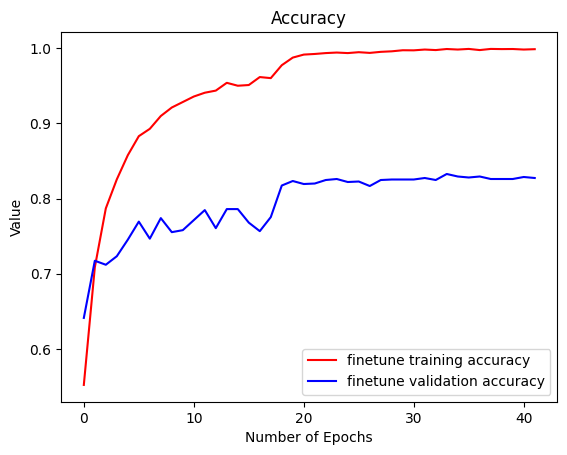

In [144]:
# Plot the loss and accuracy curves for training and validation
plt.plot(history_finetune.history['accuracy'], color='r', label="finetune training accuracy")
plt.plot(history_finetune.history['val_accuracy'], color='b', label="finetune validation accuracy")
plt.title("Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()

# Create Submission

In [145]:
file_names = []
images = []
test_directory = base_directory + 'test/'

for filename in os.listdir(test_directory):
    if filename.endswith(".jpg"):
        img_path = os.path.join(test_directory, filename)
        img = load_img(img_path, target_size=(100, 100), color_mode='grayscale')
        img_array = img_to_array(img)
        img_array = np.repeat(img_array, 3, axis=-1)
        img_array = preprocess_input(img_array)
        images.append(img_array)
        file_names.append(filename)

# In ein numpy Array konvertieren
images_array = np.array(images)


# Vorhersagen machen
y_test = model.predict(images_array)
y_pred_indices = np.argmax(y_test, axis=1)
y_pred_labels = [class_names[idx] for idx in y_pred_indices]

# DataFrame erstellen
df = pd.DataFrame({
    'Id': file_names,
    'emotions': y_pred_labels
})

# DataFrame als CSV speichern
df.to_csv('./submission.csv', index=False)

75/75 [==============================] - 2s 8ms/step


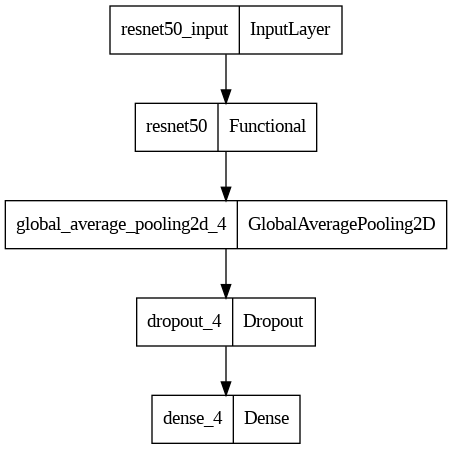

In [81]:
from keras.utils import plot_model
plot_model(model, to_file="model.png")